# Session 4: Visualizing Representations

## Assignment: Deep Dream and Style Net

<p class='lead'>
Creative Applications of Deep Learning with Google's Tensorflow  
Parag K. Mital  
Kadenze, Inc.
</p>

# Overview

In this homework, we'll first walk through visualizing the gradients of a trained convolutional network.  Recall from the last session that we had trained a variational convolutional autoencoder.  We also trained a deep convolutional network.  In both of these networks, we learned only a few tools for understanding how the model performs.  These included measuring the loss of the network and visualizing the `W` weight matrices and/or convolutional filters of the network.

During the lecture we saw how to visualize the gradients of Inception, Google's state of the art network for object recognition.  This resulted in a much more powerful technique for understanding how a network's activations transform or accentuate the representations in the input space.  We'll explore this more in Part 1.

We also explored how to use the gradients of a particular layer or neuron within a network with respect to its input for performing "gradient ascent". This resulted in Deep Dream.  We'll explore this more in Parts 2-4.

We also saw how the gradients at different layers of a convolutional network could be optimized for another image, resulting in the separation of content and style losses, depending on the chosen layers.  This allowed us to synthesize new images that shared another image's content and/or style, even if they came from separate images.  We'll explore this more in Part 5.

Finally, you'll packaged all the GIFs you create throughout this notebook and upload them to Kadenze.


<a name="learning-goals"></a>
# Learning Goals

* Learn how to inspect deep networks by visualizing their gradients
* Learn how to "deep dream" with different objective functions and regularization techniques
* Learn how to "stylize" an image using content and style losses from different images


# Table of Contents

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Part 1 - Pretrained Networks](#part-1---pretrained-networks)
  - [Graph Definition](#graph-definition)
  - [Preprocess/Deprocessing](#preprocessdeprocessing)
  - [Tensorboard](#tensorboard)
  - [A Note on 1x1 Convolutions](#a-note-on-1x1-convolutions)
  - [Network Labels](#network-labels)
  - [Using Context Managers](#using-context-managers)
- [Part 2 - Visualizing Gradients](#part-2---visualizing-gradients)
- [Part 3 - Basic Deep Dream](#part-3---basic-deep-dream)
- [Part 4 - Deep Dream Extensions](#part-4---deep-dream-extensions)
  - [Using the Softmax Layer](#using-the-softmax-layer)
  - [Fractal](#fractal)
  - [Guided Hallucinations](#guided-hallucinations)
  - [Further Explorations](#further-explorations)
- [Part 5 - Style Net](#part-5---style-net)
  - [Network](#network)
  - [Content Features](#content-features)
  - [Style Features](#style-features)
  - [Remapping the Input](#remapping-the-input)
  - [Content Loss](#content-loss)
  - [Style Loss](#style-loss)
  - [Total Variation Loss](#total-variation-loss)
  - [Training](#training)
- [Assignment Submission](#assignment-submission)

<!-- /MarkdownTOC -->

In [1]:
# First check the Python version
import sys
if sys.version_info < (3,4):
    print('You are running an older version of Python!\n\n',
          'You should consider updating to Python 3.4.0 or',
          'higher as the libraries built for this course',
          'have only been tested in Python 3.4 and higher.\n')
    print('Try installing the Python 3.5 version of anaconda'
          'and then restart `jupyter notebook`:\n',
          'https://www.continuum.io/downloads\n\n')

# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    from scipy.ndimage.filters import gaussian_filter
    import IPython.display as ipyd
    import tensorflow as tf
    from libs import utils, gif, datasets, dataset_utils, vae, dft, vgg16, nb_utils
except ImportError:
    print("Make sure you have started notebook in the same directory",
          "as the provided zip file which includes the 'libs' folder",
          "and the file 'utils.py' inside of it.  You will NOT be able",
          "to complete this assignment unless you restart jupyter",
          "notebook inside the directory created by extracting",
          "the zip file or cloning the github repo.  If you are still")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="part-1---pretrained-networks"></a>
# Part 1 - Pretrained Networks

In the libs module, you'll see that I've included a few modules for loading some state of the art networks.  These include:

* [Inception v3](https://github.com/tensorflow/models/tree/master/inception)
    - This network has been trained on ImageNet and its finaly output layer is a softmax layer denoting 1 of 1000 possible objects (+ 8 for unknown categories).  This network is about only 50MB!
* [Inception v5](https://github.com/tensorflow/models/tree/master/inception)
    - This network has been trained on ImageNet and its finaly output layer is a softmax layer denoting 1 of 1000 possible objects (+ 8 for unknown categories).  This network is about only 50MB!  It presents a few extensions to v5 which are not documented anywhere that I've found, as of yet...
* [Visual Group Geometry @ Oxford's 16 layer](http://www.robots.ox.ac.uk/~vgg/research/very_deep/)
    - This network has been trained on ImageNet and its finaly output layer is a softmax layer denoting 1 of 1000 possible objects.  This model is nearly half a gigabyte, about 10x larger in size than the inception network.  The trade off is that it is very fast.
* [Visual Group Geometry @ Oxford's Face Recognition](http://www.robots.ox.ac.uk/~vgg/software/vgg_face/)
    - This network has been trained on the VGG Face Dataset and its final output layer is a softmax layer denoting 1 of 2622 different possible people.
* [Illustration2Vec](http://illustration2vec.net)
    - This network has been trained on illustrations and manga and its final output layer is 4096 features.
* [Illustration2Vec Tag](http://illustration2vec.net)
    - Please do not use this network if you are under the age of 18 (seriously!)
    - This network has been trained on manga and its final output layer is one of 1539 labels.

When we use a pre-trained network, we load a network's definition and its weights which have already been trained.  The network's definition includes a set of operations such as convolutions, and adding biases, but all of their values, i.e. the weights, have already been trained.  

<a name="graph-definition"></a>
## Graph Definition

In the libs folder, you will see a few new modules for loading the above pre-trained networks. Each module is structured similarly to help you understand how they are loaded and include example code for using them.  Each module includes a `preprocess` function for using before sending the image to the network.  And when using deep dream techniques, we'll be using the `deprocess` function to undo the `preprocess` function's manipulations.

Let's take a look at loading one of these.  Every network except for `i2v` includes a key 'labels' denoting what labels the network has been trained on.  If you are under the age of 18, please do not use the `i2v_tag model`, as its labels are unsuitable for minors.

Let's load the libaries for the different pre-trained networks:

In [3]:
from libs import vgg16, inception, i2v

Now we can load a pre-trained network's graph and any labels.  Explore the different networks in your own time.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [4]:
# Stick w/ Inception for now, and then after you see how
# the next few sections work w/ this network, come back
# and explore the other networks.

net = inception.get_inception_model(version='v5')
# net = inception.get_inception_model(version='v3')
# net = vgg16.get_vgg_model()
# net = vgg16.get_vgg_face_model()
# net = i2v.get_i2v_model()
# net = i2v.get_i2v_tag_model()

Each network returns a dictionary with the following keys defined.  Every network has a key for "labels" except for "i2v", since this is a feature only network, e.g. an unsupervised network, and does not have labels.

In [5]:
print(net.keys())

dict_keys(['preprocess', 'graph_def', 'labels', 'deprocess'])


<a name="preprocessdeprocessing"></a>
## Preprocess/Deprocessing

Each network has a preprocessing/deprocessing function which we'll use before sending the input to the network.  This preprocessing function is slightly different for each network.  Recall from the previous sessions what preprocess we had done before sending an image to a network.  We would often normalize the input by subtracting the mean and dividing by the standard deviation.  We'd also crop/resize the input to a standard size.  We'll need to do this for each network except for the Inception network, which is a true convolutional network and does not require us to do this (will be explained in more depth later). 

Whenever we `preprocess` the image, and want to visualize the result of adding back the gradient to the input image (when we use deep dream), we'll need to use the `deprocess` function stored in the dictionary.  Let's explore how these work.  We'll confirm this is performing the inverse operation, let's try to preprocess the image, then I'll have you try to deprocess it.

0.0 1.0


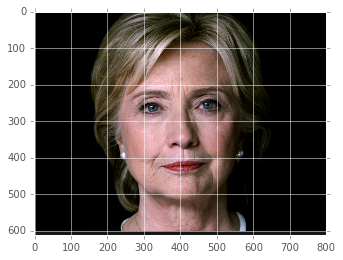

In [6]:
# First, let's get an image:
og = plt.imread('clinton.png')[..., :3]
plt.imshow(og)
print(og.min(), og.max())

Let's now try preprocessing this image.  The function for preprocessing is inside the module we used to load it.  For instance, for `vgg16`, we can find the `preprocess` function as `vgg16.preprocess`, or for `inception`, `inception.preprocess`, or for `i2v`, `i2v.preprocess`.  Or, we can just use the key `preprocess` in our dictionary `net`, as this is just convenience for us to access the corresponding preprocess function.

In [7]:
# Now call the preprocess function.  This will preprocess our
# image ready for being input to the network, except for changes
# to the dimensions.  I.e., we will still need to convert this
# to a 4-dimensional Tensor once we input it to the network.
# We'll see how that works later.
img = net['preprocess'](og)
print(img.min(), img.max())

-117.0 138.0


Let's undo the preprocessing.  Recall that the `net` dictionary has the key `deprocess` which is the function we need to use on our processed image, `img`.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

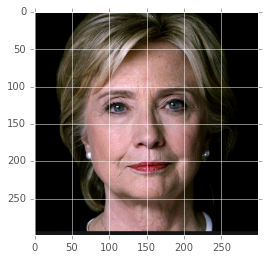

In [8]:
deprocessed = net['deprocess'](img)
plt.imshow(deprocessed)
plt.show()

<a name="tensorboard"></a>
## Tensorboard

I've added a utility module called `nb_utils` which includes a function `show_graph`.  This will use [Tensorboard](https://www.tensorflow.org/versions/r0.10/how_tos/graph_viz/index.html) to draw the computational graph defined by the various Tensorflow functions.  I didn't go over this during the lecture because there just wasn't enough time!  But explore it in your own time if it interests you, as it is a really unique tool which allows you to monitor your network's training progress via a web interface.  It even lets you monitor specific variables or processes within the network, e.g. the reconstruction of an autoencoder, without having to print to the console as we've been doing.  We'll just be using it to draw the pretrained network's graphs using the utility function I've given you.

Be sure to interact with the graph and click on the various modules.

For instance, if you've loaded the `inception` v5 network, locate the "input" to the network.  This is where we feed the image, the input placeholder (typically what we've been denoting as `X` in our own networks).  From there, it goes to the "conv2d0" variable scope (i.e. this uses the code: `with tf.variable_scope("conv2d0")` to create a set of operations with the prefix "conv2d0/".  If you expand this scope, you'll see another scope, "pre_relu".  This is created using another `tf.variable_scope("pre_relu")`, so that any new variables will have the prefix "conv2d0/pre_relu".  Finally, inside here, you'll see the convolution operation (`tf.nn.conv2d`) and the 4d weight tensor, "w" (e.g. created using `tf.get_variable`), used for convolution (and so has the name, "conv2d0/pre_relu/w".  Just after the convolution is the addition of the bias, b.  And finally after exiting the "pre_relu" scope, you should be able to see the "conv2d0" operation which applies the relu nonlinearity.  In summary, that region of the graph can be created in Tensorflow like so:

```python
input = tf.placeholder(...)
with tf.variable_scope('conv2d0'):
    with tf.variable_scope('pre_relu'):
        w = tf.get_variable(...)
        h = tf.nn.conv2d(input, h, ...)
        b = tf.get_variable(...)
        h = tf.nn.bias_add(h, b)
    h = tf.nn.relu(h)
```

In [9]:
nb_utils.show_graph(net['graph_def'])

If you open up the "mixed3a" node above (double click on it), you'll see the first "inception" module.  This network encompasses a few advanced concepts that we did not have time to discuss during the lecture, including residual connections, feature concatenation, parallel convolution streams, 1x1 convolutions, and including negative labels in the softmax layer.  I'll expand on the 1x1 convolutions here, but please feel free to skip ahead if this isn't of interest to you.

<a name="a-note-on-1x1-convolutions"></a>
## A Note on 1x1 Convolutions

The 1x1 convolutions are setting the `ksize` parameter of the kernels to 1.  This is effectively allowing you to change the number of dimensions.  Remember that you need a 4-d tensor as input to a convolution.  Let's say its dimensions are $\text{N}\ x\ \text{W}\ x\ \text{H}\ x\ \text{C}_I$, where $\text{C}_I$ represents the number of channels the image has.  Let's say it is an RGB image, then $\text{C}_I$ would be 3.  Or later in the network, if we have already convolved it, it might be 64 channels instead.  Regardless, when you convolve it w/ a $\text{K}_H\ x\ \text{K}_W\ x\ \text{C}_I\ x\ \text{C}_O$ filter, where $\text{K}_H$ is 1 and $\text{K}_W$ is also 1, then the filters size is: $1\ x\ 1\ x\ \text{C}_I$ and this is perfomed for each output channel $\text{C}_O$.  What this is doing is filtering the information only in the channels dimension, not the spatial dimensions.  The output of this convolution will be a $\text{N}\ x\ \text{W}\ x\ \text{H}\ x\ \text{C}_O$ output tensor.  The only thing that changes in the output is the number of output filters.

The 1x1 convolution operation is essentially reducing the amount of information in the channels dimensions before performing a much more expensive operation, e.g. a 3x3 or 5x5 convolution.  Effectively, it is a very clever trick for dimensionality reduction used in many state of the art convolutional networks.  Another way to look at it is that it is preseving the spatial information, but at each location, there is a fully connected network taking all the information from every input channel, $\text{C}_I$, and reducing it down to $\text{C}_O$ channels (or could easily also be up, but that is not the typical use case for this).  So it's not really a convolution, but we can use the convolution operation to perform it at every location in our image.

If you are interested in reading more about this architecture, I highly encourage you to read [Network in Network](https://arxiv.org/pdf/1312.4400v3.pdf), Christian Szegedy's work on the [Inception network](http://www.cs.unc.edu/~wliu/papers/GoogLeNet.pdf), Highway Networks, Residual Networks, and Ladder Networks.

In this course, we'll stick to focusing on the applications of these, while trying to delve as much into the code as possible.

<a name="network-labels"></a>
## Network Labels

Let's now look at the labels:

In [10]:
net['labels']

[(0, 'dummy'),
 (1, 'kit fox'),
 (2, 'English setter'),
 (3, 'Siberian husky'),
 (4, 'Australian terrier'),
 (5, 'English springer'),
 (6, 'grey whale'),
 (7, 'lesser panda'),
 (8, 'Egyptian cat'),
 (9, 'ibex'),
 (10, 'Persian cat'),
 (11, 'cougar'),
 (12, 'gazelle'),
 (13, 'porcupine'),
 (14, 'sea lion'),
 (15, 'malamute'),
 (16, 'badger'),
 (17, 'Great Dane'),
 (18, 'Walker hound'),
 (19, 'Welsh springer spaniel'),
 (20, 'whippet'),
 (21, 'Scottish deerhound'),
 (22, 'killer whale'),
 (23, 'mink'),
 (24, 'African elephant'),
 (25, 'Weimaraner'),
 (26, 'soft-coated wheaten terrier'),
 (27, 'Dandie Dinmont'),
 (28, 'red wolf'),
 (29, 'Old English sheepdog'),
 (30, 'jaguar'),
 (31, 'otterhound'),
 (32, 'bloodhound'),
 (33, 'Airedale'),
 (34, 'hyena'),
 (35, 'meerkat'),
 (36, 'giant schnauzer'),
 (37, 'titi'),
 (38, 'three-toed sloth'),
 (39, 'sorrel'),
 (40, 'black-footed ferret'),
 (41, 'dalmatian'),
 (42, 'black-and-tan coonhound'),
 (43, 'papillon'),
 (44, 'skunk'),
 (45, 'Staffordsh

In [11]:
label_i = 851
print(net['labels'][label_i])

(851, 'broom')


<a name="using-context-managers"></a>
## Using Context Managers

Up until now, we've mostly used a single `tf.Session` within a notebook and didn't give it much thought.  Now that we're using some bigger models, we're going to have to be more careful.  Using a big model and being careless with our session can result in a lot of unexpected behavior, program crashes, and out of memory errors.  The VGG network and the I2V networks are quite large.  So we'll need to start being more careful with our sessions using context managers.

Let's see how this works w/ VGG:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [12]:
# Load the VGG network.  Scroll back up to where we loaded the inception
# network if you are unsure.  It is inside the "vgg16" module...
net = vgg16.get_vgg_model()

assert(net['labels'][0] == (0, 'n01440764 tench, Tinca tinca'))

In [13]:
# Let's explicity use the CPU, since we don't gain anything using the GPU
# when doing Deep Dream (it's only a single image, benefits come w/ many images).
device = '/cpu:0'

# We'll now explicitly create a graph
g = tf.Graph()

# And here is a context manager.  We use the python "with" notation to create a context
# and create a session that only exists within this indent,  as soon as we leave it,
# the session is automatically closed!  We also tel the session which graph to use.
# We can pass a second context after the comma,
# which we'll use to be explicit about using the CPU instead of a GPU.
with tf.Session(graph=g) as sess, g.device(device):
    
    # Now load the graph_def, which defines operations and their values into `g`
    tf.import_graph_def(net['graph_def'], name='net')

In [14]:
# Now we can get all the operations that belong to the graph `g`:
names = [op.name for op in g.get_operations()]
print(names)

['net/images', 'net/mul/y', 'net/mul', 'net/split/split_dim', 'net/split', 'net/sub/y', 'net/sub', 'net/sub_1/y', 'net/sub_1', 'net/sub_2/y', 'net/sub_2', 'net/concat/concat_dim', 'net/concat', 'net/conv1_1/filter', 'net/conv1_1/Conv2D', 'net/conv1_1/biases', 'net/conv1_1/BiasAdd', 'net/conv1_1/conv1_1', 'net/conv1_2/filter', 'net/conv1_2/Conv2D', 'net/conv1_2/biases', 'net/conv1_2/BiasAdd', 'net/conv1_2/conv1_2', 'net/pool1', 'net/conv2_1/filter', 'net/conv2_1/Conv2D', 'net/conv2_1/biases', 'net/conv2_1/BiasAdd', 'net/conv2_1/conv2_1', 'net/conv2_2/filter', 'net/conv2_2/Conv2D', 'net/conv2_2/biases', 'net/conv2_2/BiasAdd', 'net/conv2_2/conv2_2', 'net/pool2', 'net/conv3_1/filter', 'net/conv3_1/Conv2D', 'net/conv3_1/biases', 'net/conv3_1/BiasAdd', 'net/conv3_1/conv3_1', 'net/conv3_2/filter', 'net/conv3_2/Conv2D', 'net/conv3_2/biases', 'net/conv3_2/BiasAdd', 'net/conv3_2/conv3_2', 'net/conv3_3/filter', 'net/conv3_3/Conv2D', 'net/conv3_3/biases', 'net/conv3_3/BiasAdd', 'net/conv3_3/conv3_

<a name="part-2---visualizing-gradients"></a>
# Part 2 - Visualizing Gradients

Now that we know how to load a network and extract layers from it, let's grab only the pooling layers:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# First find all the pooling layers in the network.  You can
# use list comprehension to iterate over all the "names" we just
# created, finding whichever ones have the name "pool" in them.
# Then be sure to append a ":0" to the names
features = ...

# Let's print them
print(features)

# This is what we want to have at the end.  You could just copy this list
# if you are stuck!
assert(features == ['net/pool1:0', 'net/pool2:0', 'net/pool3:0', 'net/pool4:0', 'net/pool5:0'])

Let's also grab the input layer:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Use the function 'get_tensor_by_name' and the 'names' array to help you
# get the first tensor in the network.  Remember you have to add ":0" to the
# name to get the output of an operation which is the tensor.
x = ...

assert(x.name == 'net/images:0')

We'll now try to find the gradient activation that maximizes a layer with respect to the input layer `x`.

In [ ]:
def plot_gradient(img, x, feature, g, device='/cpu:0'):
    """Let's visualize the network's gradient activation
    when backpropagated to the original input image.  This
    is effectively telling us which pixels contribute to the
    predicted layer, class, or given neuron with the layer"""
    
    # We'll be explicit about the graph and the device
    # by using a context manager:
    with tf.Session(graph=g) as sess, g.device(device):
        saliency = tf.gradients(tf.reduce_mean(feature), x)
        this_res = sess.run(saliency[0], feed_dict={x: img})
        grad = this_res[0] / np.max(np.abs(this_res))
        return grad

Let's try this w/ an image now.  We're going to use the `plot_gradient` function to help us.  This is going to take our input image, run it through the network up to a layer, find the gradient of the mean of that layer's activation with respect to the input image, then backprop that gradient back to the input layer.  We'll then visualize the gradient by normalizing it's values using the `utils.normalize` function.

In [ ]:
og = plt.imread('clinton.png')[..., :3]
img = net['preprocess'](og)[np.newaxis]

fig, axs = plt.subplots(1, len(features), figsize=(20, 10))

for i in range(len(features)):
    axs[i].set_title(features[i])
    grad = plot_gradient(img, x, g.get_tensor_by_name(features[i]), g)
    axs[i].imshow(utils.normalize(grad))

<a name="part-3---basic-deep-dream"></a>
# Part 3 - Basic Deep Dream

In the lecture we saw how Deep Dreaming takes the backpropagated gradient activations and simply adds it to the image, running the same process again and again in a loop.  We also saw many tricks one can add to this idea, such as infinitely zooming into the image by cropping and scaling, adding jitter by randomly moving the image around, or adding constraints on the total activations.

Have a look here for inspiration:

https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html  


https://photos.google.com/share/AF1QipPX0SCl7OzWilt9LnuQliattX4OUCj_8EP65_cTVnBmS1jnYgsGQAieQUc1VQWdgQ?key=aVBxWjhwSzg2RjJWLWRuVFBBZEN1d205bUdEMnhB  

https://mtyka.github.io/deepdream/2016/02/05/bilateral-class-vis.html

Let's stick the necessary bits in a function and try exploring how deep dream amplifies the representations of the chosen layers:

In [ ]:
def dream(img, gradient, step, net, x, n_iterations=50, plot_step=10):
    # Copy the input image as we'll add the gradient to it in a loop
    img_copy = img.copy()

    fig, axs = plt.subplots(1, n_iterations // plot_step, figsize=(20, 10))

    with tf.Session(graph=g) as sess, g.device(device):
        for it_i in range(n_iterations):

            # This will calculate the gradient of the layer we chose with respect to the input image.
            this_res = sess.run(gradient[0], feed_dict={x: img_copy})[0]

            # Let's normalize it by the maximum activation
            this_res /= (np.max(np.abs(this_res) + 1e-8))
            
            # Or alternatively, we can normalize by standard deviation
            # this_res /= (np.std(this_res) + 1e-8)
            
            # Or we could use the `utils.normalize function:
            # this_res = utils.normalize(this_res)
            
            # Experiment with all of the above options.  They will drastically
            # effect the resulting dream, and really depend on the network
            # you use, and the way the network handles normalization of the
            # input image, and the step size you choose!  Lots to explore!

            # Then add the gradient back to the input image
            # Think about what this gradient represents?
            # It says what direction we should move our input
            # in order to meet our objective stored in "gradient"
            img_copy += this_res * step

            # Plot the image
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])
                axs[it_i // plot_step].imshow(m)

In [ ]:
# We'll run it for 3 iterations
n_iterations = 3

# Think of this as our learning rate.  This is how much of
# the gradient we'll add back to the input image
step = 1.0

# Every 1 iterations, we'll plot the current deep dream
plot_step = 1

Let's now try running Deep Dream for every feature, each of our 5 pooling layers.  We'll need to get the layer corresponding to our feature.  Then find the gradient of this layer's mean activation with respect to our input, `x`.  Then pass these to our `dream` function.  This can take awhile (about 10 minutes using the CPU on my Macbook Pro).

In [ ]:
for feature_i in range(len(features)):
    with tf.Session(graph=g) as sess, g.device(device):
        # Get a feature layer
        layer = g.get_tensor_by_name(features[feature_i])

        # Find the gradient of this layer's mean activation
        # with respect to the input image
        gradient = tf.gradients(tf.reduce_mean(layer), x)
        
        # Dream w/ our image
        dream(img, gradient, step, net, x, n_iterations=n_iterations, plot_step=plot_step)

Instead of using an image, we can use an image of noise and see how it "hallucinates" the representations that the layer most responds to:

In [ ]:
noise = net['preprocess'](
    np.random.rand(256, 256, 3) * 0.1 + 0.45)[np.newaxis]

We'll do the same thing as before, now w/ our noise image:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
for feature_i in range(len(features)):
    with tf.Session(graph=g) as sess, g.device(device):
        # Get a feature layer
        layer = ...

        # Find the gradient of this layer's mean activation
        # with respect to the input image
        gradient = ...
        
        # Dream w/ the noise image.  Complete this!
        dream(...)

<a name="part-4---deep-dream-extensions"></a>
# Part 4 - Deep Dream Extensions

As we saw in the lecture, we can also use the final softmax layer of a network to use during deep dream.  This allows us to be explicit about the object we want hallucinated in an image.

<a name="using-the-softmax-layer"></a>
## Using the Softmax Layer

Let's get another image to play with, preprocess it, and then make it 4-dimensional.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Load your own image here
og = ...
plt.imshow(og)

# Preprocess the image and make sure it is 4-dimensional by adding a new axis to the 0th dimension:
img = ...

assert(img.ndim == 4)

In [ ]:
# Let's get the softmax layer
print(names[-2])
layer = g.get_tensor_by_name(names[-2] + ":0")

# And find its shape
with tf.Session(graph=g) as sess, g.device(device):
    layer_shape = tf.shape(layer).eval(feed_dict={x:img})

# We can find out how many neurons it has by feeding it an image and
# calculating the shape.  The number of output channels is the last dimension.
n_els = layer_shape[-1]

In [ ]:
# Let's pick a label.  First let's print out every label and then find one we like:
print(net['labels'])

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Pick a neuron.  Or pick a random one.  This should be 0-n_els
neuron_i = ...

print(net['labels'][neuron_i])
assert(neuron_i >= 0 and neuron_i < n_els)

In [ ]:
# And we'll create an activation of this layer which is very close to 0
layer_vec = np.ones(layer_shape) / 100.0

# Except for the randomly chosen neuron which will be very close to 1
layer_vec[..., neuron_i] = 0.99

Let's decide on some parameters of our deep dream.  We'll need to decide how many iterations to run for.  And we'll plot the result every few iterations, also saving it so that we can produce a GIF.  And at every iteration, we need to decide how much to ascend our gradient.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Explore different parameters for this section.
n_iterations = 51

plot_step = 5

# If you use a different network, you will definitely need to experiment
# with the step size, as each network normalizes the input image differently.
step = 0.2

Now let's dream.  We're going to define a context manager to create a session and use our existing graph, and make sure we use the CPU device, as there is no gain in using GPU, and we have much more CPU memory than GPU memory.

In [ ]:
imgs = []
with tf.Session(graph=g) as sess, g.device(device):
    gradient = tf.gradients(tf.reduce_max(layer), x)

    # Copy the input image as we'll add the gradient to it in a loop
    img_copy = img.copy()

    with tf.Session(graph=g) as sess, g.device(device):
        for it_i in range(n_iterations):

            # This will calculate the gradient of the layer we chose with respect to the input image.
            this_res = sess.run(gradient[0], feed_dict={
                    x: img_copy, layer: layer_vec})[0]
            
            # Let's normalize it by the maximum activation
            this_res /= (np.max(np.abs(this_res) + 1e-8))
            
            # Or alternatively, we can normalize by standard deviation
            # this_res /= (np.std(this_res) + 1e-8)

            # Then add the gradient back to the input image
            # Think about what this gradient represents?
            # It says what direction we should move our input
            # in order to meet our objective stored in "gradient"
            img_copy += this_res * step

            # Plot the image
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])

                plt.figure(figsize=(5, 5))
                plt.grid('off')
                plt.imshow(m)
                plt.show()
                
                imgs.append(m)
                

In [ ]:
# Save the gif
gif.build_gif(imgs, saveto='softmax.gif')

In [ ]:
ipyd.Image(url='softmax.gif?i={}'.format(
        np.random.rand()), height=300, width=300)

<a name="fractal"></a>
## Fractal

During the lecture we also saw a simple trick for creating an infinite fractal: crop the image and then resize it.  This can produce some lovely aesthetics and really show some strong object hallucinations if left long enough and with the right parameters for step size/normalization/regularization.  Feel free to experiment with the code below, adding your own regularizations as shown in the lecture to produce different results!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
n_iterations = 101
plot_step = 10
step = 0.1
crop = 1
imgs = []

n_imgs, height, width, *ch = img.shape

with tf.Session(graph=g) as sess, g.device(device):
    # Explore changing the gradient here from max to mean
    # or even try using different concepts we learned about
    # when creating style net, such as using a total variational
    # loss on `x`.
    gradient = tf.gradients(tf.reduce_max(layer), x)

    # Copy the input image as we'll add the gradient to it in a loop
    img_copy = img.copy()

    with tf.Session(graph=g) as sess, g.device(device):
        for it_i in range(n_iterations):

            # This will calculate the gradient of the layer
            # we chose with respect to the input image.
            this_res = sess.run(gradient[0], feed_dict={
                    x: img_copy, layer: layer_vec})[0]
            
            # This is just one way we could normalize the
            # gradient.  It helps to look at the range of your image's
            # values, e.g. if it is 0 - 1, or -115 to +115,
            # and then consider the best way to normalize the gradient.
            # For some networks, it might not even be necessary
            # to perform this normalization, especially if you
            # leave the dream to run for enough iterations.
            # this_res = this_res / (np.std(this_res) + 1e-10)
            this_res = this_res / (np.max(np.abs(this_res)) + 1e-10)

            # Then add the gradient back to the input image
            # Think about what this gradient represents?
            # It says what direction we should move our input
            # in order to meet our objective stored in "gradient"
            img_copy += this_res * step
            
            # Optionally, we could apply any number of regularization
            # techniques... Try exploring different ways of regularizing
            # gradient. ascent process.  If you are adventurous, you can
            # also explore changing the gradient above using a
            # total variational loss, as we used in the style net
            # implementation during the lecture.  I leave that to you
            # as an exercise!

            # Crop a 1 pixel border from height and width
            img_copy = img_copy[:, crop:-crop, crop:-crop, :]

            # Resize (Note: in the lecture, we used scipy's resize which
            # could not resize images outside of 0-1 range, and so we had
            # to store the image ranges.  This is a much simpler resize
            # method that allows us to `preserve_range`.)
            img_copy = resize(img_copy[0], (height, width), order=3,
                         clip=False, preserve_range=True
                         )[np.newaxis].astype(np.float32)

            # Plot the image
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])

                plt.grid('off')
                plt.imshow(m)
                plt.show()
                
                imgs.append(m)

# Create a GIF
gif.build_gif(imgs, saveto='fractal.gif')

In [ ]:
ipyd.Image(url='fractal.gif?i=2', height=300, width=300)

<a name="guided-hallucinations"></a>
## Guided Hallucinations

Instead of following the gradient of an arbitrary mean or max of a particular layer's activation, or a particular object that we want to synthesize, we can also try to guide our image to look like another image.  One way to try this is to take one image, the guide, and find the features at a particular layer or layers.  Then, we take our synthesis image and find the gradient which makes it's own layers activations look like the guide image.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Replace these with your own images!
guide_og = plt.imread(...)[..., :3]
dream_og = plt.imread(...)[..., :3]

assert(guide_og.ndim == 3 and guide_og.shape[-1] == 3)
assert(dream_og.ndim == 3 and dream_og.shape[-1] == 3)

Preprocess both images:

In [ ]:
guide_img = net['preprocess'](guide_og)[np.newaxis]
dream_img = net['preprocess'](dream_og)[np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(guide_og)
axs[1].imshow(dream_og)

Like w/ Style Net, we are going to measure how similar the features in the guide image are to the dream images.  In order to do that, we'll calculate the dot product.  Experiment with other measures such as l1 or l2 loss to see how this impacts the resulting Dream!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
x = g.get_tensor_by_name(names[0] + ":0")

# Experiment with the weighting
feature_loss_weight = 1.0

with tf.Session(graph=g) as sess, g.device(device):
    feature_loss = tf.Variable(0.0)
    
    # Explore different layers/subsets of layers.  This is just an example.
    for feature_i in features[3:5]:

        # Get the activation of the feature
        layer = g.get_tensor_by_name(feature_i)
        
        # Do the same for our guide image
        guide_layer = sess.run(layer, feed_dict={x: guide_img})
        
        # Now we need to measure how similar they are!
        # We'll use the dot product, which requires us to first reshape both
        # features to a 2D vector.  But you should experiment with other ways
        # of measuring similarity such as l1 or l2 loss.
        
        # Reshape each layer to 2D vector
        layer = tf.reshape(layer, [-1, 1])
        guide_layer = guide_layer.reshape(-1, 1)
        
        # Now calculate their dot product
        correlation = tf.matmul(guide_layer.T, layer)
        
        # And weight the loss by a factor so we can control its influence
        feature_loss += feature_loss_weight * correlation

We'll now use another measure that we saw when developing Style Net during the lecture.  This measure the pixel to pixel difference of neighboring pixels.  What we're doing when we try to optimize a gradient that makes the mean differences small is saying, we want the difference to be low.  This allows us to smooth our image in the same way that we did using the Gaussian to blur the image.  

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
n_img, height, width, ch = dream_img.shape

# We'll weight the overall contribution of the total variational loss
# Experiment with this weighting
tv_loss_weight = 1.0

with tf.Session(graph=g) as sess, g.device(device):
    # Penalize variations in neighboring pixels, enforcing smoothness
    dx = tf.square(x[:, :height - 1, :width - 1, :] - x[:, :height - 1, 1:, :])
    dy = tf.square(x[:, :height - 1, :width - 1, :] - x[:, 1:, :width - 1, :])
    
    # We will calculate their difference raised to a power to push smaller
    # differences closer to 0 and larger differences higher.
    # Experiment w/ the power you raise this to to see how it effects the result
    tv_loss = tv_loss_weight * tf.reduce_mean(tf.pow(dx + dy, 1.2))

Now we train just like before, except we'll need to combine our two loss terms, `feature_loss` and `tv_loss` by simply adding them!  The one thing we have to keep in mind is that we want to minimize the `tv_loss` while maximizing the `feature_loss`.  That means we'll need to use the negative `tv_loss` and the positive `feature_loss`.  As an experiment, try just optimizing the `tv_loss` and removing the `feature_loss` from the `tf.gradients` call.  What happens?

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Experiment with the step size!
step = 0.1

imgs = []

with tf.Session(graph=g) as sess, g.device(device):
    # Experiment with just optimizing the tv_loss or negative tv_loss to understand what it is doing!
    gradient = tf.gradients(-tv_loss + feature_loss, x)

    # Copy the input image as we'll add the gradient to it in a loop
    img_copy = dream_img.copy()

    with tf.Session(graph=g) as sess, g.device(device):
        sess.run(tf.initialize_all_variables())
        
        for it_i in range(n_iterations):

            # This will calculate the gradient of the layer we chose with respect to the input image.
            this_res = sess.run(gradient[0], feed_dict={x: img_copy})[0]
            
            # Let's normalize it by the maximum activation
            this_res /= (np.max(np.abs(this_res) + 1e-8))
            
            # Or alternatively, we can normalize by standard deviation
            # this_res /= (np.std(this_res) + 1e-8)

            # Then add the gradient back to the input image
            # Think about what this gradient represents?
            # It says what direction we should move our input
            # in order to meet our objective stored in "gradient"
            img_copy += this_res * step

            # Plot the image
            if (it_i + 1) % plot_step == 0:
                m = net['deprocess'](img_copy[0])

                plt.figure(figsize=(5, 5))
                plt.grid('off')
                plt.imshow(m)
                plt.show()
                
                imgs.append(m)

gif.build_gif(imgs, saveto='guided.gif')                

In [ ]:
ipyd.Image(url='guided.gif?i=0', height=300, width=300)

<a name="further-explorations"></a>
## Further Explorations

In the `libs` module, I've included a `deepdream` module which has two functions for performing Deep Dream and the Guided Deep Dream.  Feel free to explore these to create your own deep dreams.

<a name="part-5---style-net"></a>
# Part 5 - Style Net

We'll now work on creating our own style net implementation.  We've seen all the steps for how to do this during the lecture, and you can always refer to the [Lecture Transcript](lecture-4.ipynb) if you need to.  I want to you to explore using different networks and different layers in creating your content and style losses.  This is completely unexplored territory so it can be frustrating to find things that work.  Think of this as your empty canvas!  If you are really stuck, you will find a `stylenet` implementation under the `libs` module that you can use instead.

Have a look here for inspiration:

https://mtyka.github.io/code/2015/10/02/experiments-with-style-transfer.html  

http://kylemcdonald.net/stylestudies/

<a name="network"></a>
## Network

Let's reset the graph and load up a network.  I'll include code here for loading up any of our pretrained networks so you can explore each of them!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
sess.close()
tf.reset_default_graph()

# Stick w/ VGG for now, and then after you see how
# the next few sections work w/ this network, come back
# and explore the other networks.

net = vgg16.get_vgg_model()
# net = vgg16.get_vgg_face_model()
# net = inception.get_inception_model(version='v5')
# net = inception.get_inception_model(version='v3')
# net = i2v.get_i2v_model()
# net = i2v.get_i2v_tag_model()

In [ ]:
# Let's explicity use the CPU, since we don't gain anything using the GPU
# when doing Deep Dream (it's only a single image, benefits come w/ many images).
device = '/cpu:0'

# We'll now explicitly create a graph
g = tf.Graph()

Let's now import the graph definition into our newly created Graph using a context manager and specifying that we want to use the CPU.

In [ ]:
# And here is a context manager.  We use the python "with" notation to create a context
# and create a session that only exists within this indent,  as soon as we leave it,
# the session is automatically closed!  We also tel the session which graph to use.
# We can pass a second context after the comma,
# which we'll use to be explicit about using the CPU instead of a GPU.
with tf.Session(graph=g) as sess, g.device(device):
    
    # Now load the graph_def, which defines operations and their values into `g`
    tf.import_graph_def(net['graph_def'], name='net')

Let's then grab the names of every operation in our network:

In [ ]:
names = [op.name for op in g.get_operations()]

Now we need an image for our content image and another one for our style image.

In [ ]:
content_og = plt.imread('arles.png')[..., :3]
style_og = plt.imread('clinton.png')[..., :3]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(content_og)
axs[0].set_title('Content Image')
axs[0].grid('off')
axs[1].imshow(style_og)
axs[1].set_title('Style Image')
axs[1].grid('off')

# We'll save these with a specific name to include in your submission
plt.imsave(arr=content_og, fname='content.png')
plt.imsave(arr=style_og, fname='style.png')

In [ ]:
content_img = net['preprocess'](content_og)[np.newaxis]
style_img = net['preprocess'](style_og)[np.newaxis]

Let's see what the network classifies these images as just for fun:

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Grab the tensor defining the input to the network
x = ...

# And grab the tensor defining the softmax layer of the network
softmax = ...

for img in [content_img, style_img]:
    with tf.Session(graph=g) as sess, g.device('/cpu:0'):
        # Remember from the lecture that we have to set the dropout
        # "keep probability" to 1.0.
        res = softmax.eval(feed_dict={x: img,
                    'net/dropout_1/random_uniform:0': [[1.0]],
                    'net/dropout/random_uniform:0': [[1.0]]})[0]
        print([(res[idx], net['labels'][idx])
               for idx in res.argsort()[-5:][::-1]])

<a name="content-features"></a>
## Content Features

We're going to need to find the layer or layers we want to use to help us define our "content loss".  Recall from the lecture when we used VGG, we used the 4th convolutional layer.

In [ ]:
print(names)

Pick a layer for using for the content features.  If you aren't using VGG remember to get rid of the dropout stuff!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Experiment w/ different layers here.  You'll need to change this if you 
# use another network!
content_layer = 'net/conv3_2/conv3_2:0'

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_features = g.get_tensor_by_name(content_layer).eval(
            session=sess,
            feed_dict={x: content_img,
                'net/dropout_1/random_uniform:0': [[1.0]],
                'net/dropout/random_uniform:0': [[1.0]]})

<a name="style-features"></a>
## Style Features

Let's do the same thing now for the style features.  We'll use more than 1 layer though so we'll append all the features in a list.  If you aren't using VGG remember to get rid of the dropout stuff!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
# Experiment with different layers and layer subsets.  You'll need to change these
# if you use a different network!
style_layers = ['net/conv1_1/conv1_1:0',
                'net/conv2_1/conv2_1:0',
                'net/conv3_1/conv3_1:0',
                'net/conv4_1/conv4_1:0',
                'net/conv5_1/conv5_1:0']
style_activations = []

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    for style_i in style_layers:
        style_activation_i = g.get_tensor_by_name(style_i).eval(
            feed_dict={x: style_img,
                    'net/dropout_1/random_uniform:0': [[1.0]],
                    'net/dropout/random_uniform:0': [[1.0]]})
        style_activations.append(style_activation_i)

Now we find the gram matrix which we'll use to optimize our features.

In [ ]:
style_features = []
for style_activation_i in style_activations:
    s_i = np.reshape(style_activation_i, [-1, style_activation_i.shape[-1]])
    gram_matrix = np.matmul(s_i.T, s_i) / s_i.size
    style_features.append(gram_matrix.astype(np.float32))

<a name="remapping-the-input"></a>
## Remapping the Input

We're almost done building our network.  We just have to change the input to the network to become "trainable".  Instead of a placeholder, we'll have a `tf.Variable`, which allows it to be trained.  We could set this to the content image, another image entirely, or an image of noise.  Experiment with all three options!

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
tf.reset_default_graph()
g = tf.Graph()

# Get the network again
net = vgg16.get_vgg_model()

# Load up a session which we'll use to import the graph into.
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    # We can set the `net_input` to our content image
    # or perhaps another image
    # or an image of noise
#     net_input = tf.Variable(content_img / 255.0)
    net_input = tf.get_variable(
       name='input',
       shape=content_img.shape,
       dtype=tf.float32,
       initializer=tf.random_normal_initializer(
           mean=np.mean(content_img), stddev=np.std(content_img)))
    
    # Now we load the network again, but this time replacing our placeholder
    # with the trainable tf.Variable
    tf.import_graph_def(
        net['graph_def'],
        name='net',
        input_map={'images:0': net_input})

<a name="content-loss"></a>
## Content Loss

In the lecture we saw that we'll simply find the l2 loss between our content layer features.

In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    content_loss = tf.nn.l2_loss((g.get_tensor_by_name(content_layer) -
                                 content_features) /
                                 content_features.size)

<a name="style-loss"></a>
## Style Loss

Instead of straight l2 loss on the raw feature activations, we're going to calculate the gram matrix and find the loss between these.  Intuitively, this is finding what is common across all convolution filters, and trying to enforce the commonality between the synthesis and style image's gram matrix.

In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    style_loss = np.float32(0.0)
    for style_layer_i, style_gram_i in zip(style_layers, style_features):
        layer_i = g.get_tensor_by_name(style_layer_i)
        layer_shape = layer_i.get_shape().as_list()
        layer_size = layer_shape[1] * layer_shape[2] * layer_shape[3]
        layer_flat = tf.reshape(layer_i, [-1, layer_shape[3]])
        gram_matrix = tf.matmul(tf.transpose(layer_flat), layer_flat) / layer_size
        style_loss = tf.add(style_loss, tf.nn.l2_loss((gram_matrix - style_gram_i) / np.float32(style_gram_i.size)))

<a name="total-variation-loss"></a>
## Total Variation Loss

And just like w/ guided hallucinations, we'll try to enforce some smoothness using a total variation loss.

In [ ]:
def total_variation_loss(x):
    h, w = x.get_shape().as_list()[1], x.get_shape().as_list()[1]
    dx = tf.square(x[:, :h-1, :w-1, :] - x[:, :h-1, 1:, :])
    dy = tf.square(x[:, :h-1, :w-1, :] - x[:, 1:, :w-1, :])
    return tf.reduce_sum(tf.pow(dx + dy, 1.25))

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    tv_loss = total_variation_loss(net_input)

<a name="training"></a>
## Training

We're almost ready to train!  Let's just combine our three loss measures and stick it in an optimizer.

<h3><font color='red'>TODO! COMPLETE THIS SECTION!</font></h3>

In [ ]:
with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    # Experiment w/ the weighting of these!  They produce WILDLY different
    # results.
    loss = 5.0 * content_loss + 1.0 * style_loss + 0.001 * tv_loss
    optimizer = tf.train.AdamOptimizer(0.05).minimize(loss)

And now iterate!  Feel free to play with the number of iterations or how often you save an image.  If you use a different network to VGG, then you will not need to feed in the dropout parameters like I've done here.

In [ ]:
imgs = []
n_iterations = 100

with tf.Session(graph=g) as sess, g.device('/cpu:0'):
    sess.run(tf.initialize_all_variables())

    # map input to noise
    og_img = net_input.eval()
    
    for it_i in range(n_iterations):
        _, this_loss, synth = sess.run([optimizer, loss, net_input], feed_dict={
                    'net/dropout_1/random_uniform:0': np.ones(
                        g.get_tensor_by_name(
                            'net/dropout_1/random_uniform:0'
                        ).get_shape().as_list()),
                    'net/dropout/random_uniform:0': np.ones(
                        g.get_tensor_by_name(
                            'net/dropout/random_uniform:0'
                        ).get_shape().as_list())
                })
        print("%d: %f, (%f - %f)" %
            (it_i, this_loss, np.min(synth), np.max(synth)))
        if it_i % 5 == 0:
            m = vgg16.deprocess(synth[0])
            imgs.append(m)
            plt.imshow(m)
            plt.show()
    gif.build_gif(imgs, saveto='stylenet.gif')

In [ ]:
ipyd.Image(url='stylenet.gif?i=0', height=300, width=300)

<a name="assignment-submission"></a>
# Assignment Submission

After you've completed the notebook, create a zip file of the current directory using the code below.  This code will make sure you have included this completed ipython notebook and the following files named exactly as:

<pre>
    session-4/
      session-4.ipynb
      softmax.gif
      fractal.gif
      guided.gif
      content.png
      style.png
      stylenet.gif
</pre>

You'll then submit this zip file for your third assignment on Kadenze for "Assignment 4: Deep Dream and Style Net"!  Remember to complete the rest of the assignment, gallery commenting on your peers work, to receive full credit!  If you have any questions, remember to reach out on the forums and connect with your peers or with me.

To get assessed, you'll need to be a premium student!  This will allow you to build an online portfolio of all of your work and receive grades.  If you aren't already enrolled as a student, register now at http://www.kadenze.com/ and join the [#CADL](https://twitter.com/hashtag/CADL) community to see what your peers are doing! https://www.kadenze.com/courses/creative-applications-of-deep-learning-with-tensorflow/info

Also, if you share any of the GIFs on Facebook/Twitter/Instagram/etc..., be sure to use the #CADL hashtag so that other students can find your work!

In [ ]:
utils.build_submission('session-4.zip',
                       ('softmax.gif',
                        'fractal.gif',
                        'guided.gif',
                        'content.png',
                        'style.png',
                        'stylenet.gif'))